In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=746f11bd98c80d762596e41979527c4730962ca3f8f30684ae044481aa0a39fb
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession


In [5]:
import pyspark

In [6]:
from pyspark.sql import SparkSession

In [7]:
spark=SparkSession.builder.appName("bank").getOrCreate()
spark

In [8]:
data=spark.read.csv('/content/bank.csv',header=True,inferSchema=True)

In [9]:
data.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

In [17]:
#Data Cleaning
data=data.dropna()
data=data.dropDuplicates()

In [18]:
# Filtering rows
data.count()

11162

In [15]:
data.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [ ]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
type(data)

pyspark.sql.dataframe.DataFrame

In [ ]:
data.groupby('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [ ]:
data.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             11162|  11162|   11162|    11162|  11162|             11162|  11162|11162|   11162|             11162|11162|             11162|             11162|             11162|             11162|   11162|  11162|
|   mean|41.231947679627304|   null|    null|     null|   null|1528.5385235620856|   null| null|    null

In [ ]:
#feature scaling
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

stages = []

for categoricalCol in categoricalColumns:

    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

    stages += [stringIndexer, encoder]

In [ ]:
print(stages)

[StringIndexer_94ef65b240ae, OneHotEncoder_51ae812fc924, StringIndexer_ad036886a5f2, OneHotEncoder_978b9efcef74, StringIndexer_7e481eec208e, OneHotEncoder_1db2f962cf6c, StringIndexer_05f0259e466c, OneHotEncoder_6078ffa9e8ed, StringIndexer_5a0e55b88a8e, OneHotEncoder_49be3f1b8345, StringIndexer_c87ca6304426, OneHotEncoder_d1f5e7dfdd3b, StringIndexer_3f69cd1cd9d0, OneHotEncoder_c5e68b08ae3e, StringIndexer_70663f98e075, OneHotEncoder_d1e7eb7356da]


In [ ]:
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [ ]:
data = data.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = data.columns
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel =pipeline.fit(data)
data = pipelineModel.transform(data)
selectedCols = ['label', 'features'] + cols
data= data.select(selectedCols)
data.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame(data.take(5), columns=data.columns)

,label,features,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,admin.,married,secondary,no,2343,yes,no,unknown,1042,1,-1,0,unknown,yes
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56,admin.,married,secondary,no,45,no,no,unknown,1467,1,-1,0,unknown,yes
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,technician,married,secondary,no,1270,yes,no,unknown,1389,1,-1,0,unknown,yes
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",55,services,married,secondary,no,2476,yes,no,unknown,579,1,-1,0,unknown,yes
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,admin.,married,tertiary,no,184,no,no,unknown,673,2,-1,0,unknown,yes


In [ ]:
data.show()

+-----+--------------------+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|label|            features|age|        job| marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|  1.0|(30,[3,11,13,16,1...| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[3,11,13,16,1...| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[2,11,13,16,1...| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|    1389|       1|   -1|       0| unknown|    yes|
|  1.0|(30,[4,11,13,16,1...| 55|   services| married|secondary|     no|   2476|    yes|  no|un

In [ ]:
#splitting data in train test split
train, test = data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


Logistic Regression classifier

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)


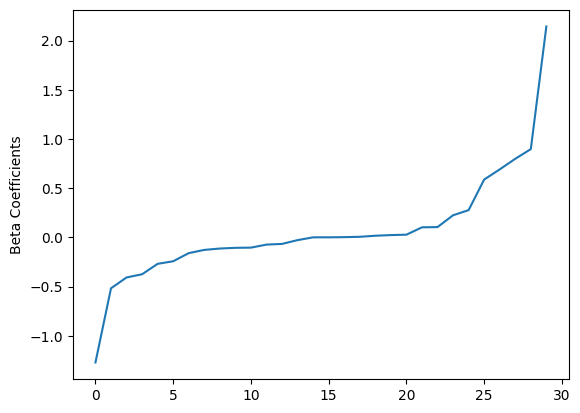

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

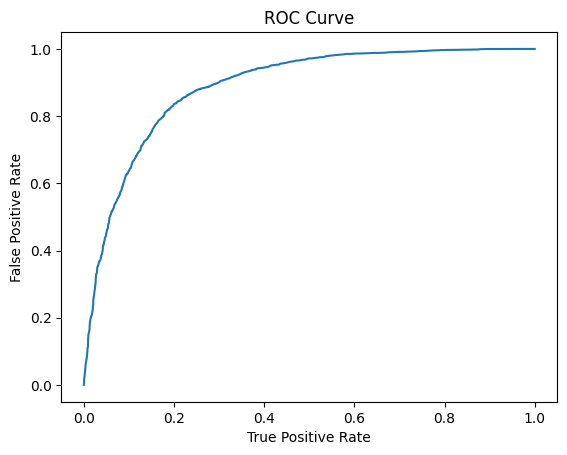

Training set areaUnderROC: 0.8877385690600346


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

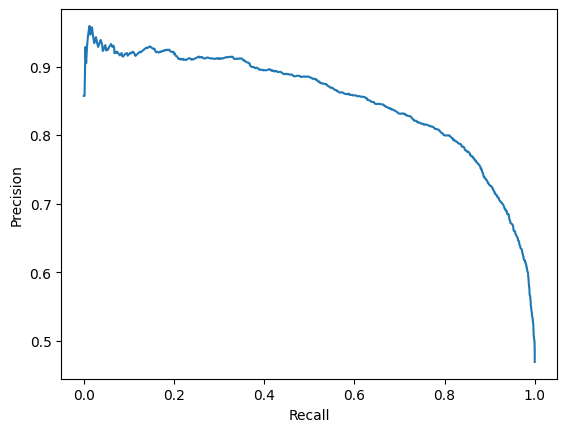

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:

predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93084854518128...|       0.0|[0.87334331124860...|
| 49|management|  0.0|[1.92783695472097...|       0.0|[0.87300981013433...|
| 52|management|  0.0|[-0.7737627890181...|       1.0|[0.31566570209267...|
| 53|management|  0.0|[0.94708137344074...|       0.0|[0.72052784002179...|
| 58|management|  0.0|[2.44657764692457...|       0.0|[0.92031082026376...|
| 32|management|  0.0|[1.28386077546037...|       0.0|[0.78310624913886...|
| 57|management|  0.0|[1.05745870556531...|       0.0|[0.74220460119091...|
| 52|management|  0.0|[3.25200815517462...|       0.0|[0.96274520587479...|
| 46|management|  0.0|[2.24978402804239...|       0.0|[0.90463190417562...|
| 31|management|  0.0|[1.47121751117284...|       0.0|[0.81324237120150...|
+---+-------

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.885643189559481


Decision tree classifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.885643189559481
